# Why Does it Matter to Analyze your Cycling Data

Analyzing one-year of indoor cycling training sessions

![_HGI1327.jpg](_HGI1327.jpg)

## Introduction

In Belo Horizonte (Brazil), there is a indoor cycling studio called [DCycle](https://dcycle.academiadtox.com.br/) with six units of a professional bycicle: the [Wattbike](https://international.wattbike.com/). It is considered one of the best indoor bikes in the world, being endorsed by several elite sports teams and athletes. Our coach uses a software called [PerfPro](https://perfprostudio.com/Default.aspx) to prepare training courses that simulate real-life cycling scenarios. It is also capable of connecting to each Wattbike, collecting and processing its available data.

The data used in this notebook consists in my consolidated tranining performances from 2021 and 2022. This data can be very useful to find patterns in the performance, thus enabling interesting insights. 

## Objectives

This analysis aims to generate initial insights based on this data, based on the following set of questions:

1. How is my performance evolving over time?
2. How is my pedalling technique?
3. Can I group traininig sessions into different categories?

In [211]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
from scipy.cluster import hierarchy
from scipy.spatial.distance import squareform
from scipy.stats import spearmanr
from collections import defaultdict 

plt.style.use('ggplot')

## Data Preparation
### Description

The data is stored in the *performances_wattbike.csv* file, available in this repository. Each row corresponds to a training session associated to a given athlete ID, and contains the following information already calculated by PerfPro:

* Duration in minutes
* Average Power, Speed, Calories, RPM and Hear Rate (HR)
* Leg Balance
* [TSS (Training Stress Score) and Normalized Power (NP)](https://www.trainingpeaks.com/learn/articles/normalized-power-intensity-factor-training-stress/)
* Power EWMA
* Average, Mininum and Max Load
* The session's [FTP](https://www.cyclingweekly.com/fitness/ftp-cycling-363865)

Another dataset use was extracted from Google Fit, where I manually insert my body weight each time I go to the gym. It is stored in the *weight_self.csv* file, and contains a timestamp and the weight value in kilograms.

In [212]:
raw_data = pd.read_csv('performances_wattbike_self.csv', parse_dates=['dateStamp'])

In [213]:
raw_weight = pd.read_csv('weight_self.csv', parse_dates=['Timestamp'])

### Data Preprocessing

#### Performances

There aren't any missing values in the datasets, as evaluated below. 

In [214]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76 entries, 0 to 75
Data columns (total 21 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   ID            76 non-null     int64         
 1   Age           76 non-null     int64         
 2   Gender        76 non-null     object        
 3   units         76 non-null     object        
 4   dateStamp     76 non-null     datetime64[ns]
 5   userWeight    76 non-null     object        
 6   minutes       76 non-null     float64       
 7   aveSpeed      76 non-null     float64       
 8   aveWatts      76 non-null     float64       
 9   aveHR         76 non-null     float64       
 10  aveRPMs       76 non-null     float64       
 11  NormPower     76 non-null     float64       
 12  AveCalories   76 non-null     float64       
 13  avePowerL     76 non-null     float64       
 14  avePowerR     76 non-null     float64       
 15  EWMA          76 non-null     float64     

The reason behind this is that PerfPro already applies some prepocessing to the data. For instance, when an athlete does not use a HR monitor, it is stored as 0.0 instead of None. Therefore, the first pre-processing step is to convert these values to NaN, to make sure they have the correct meaning. Then, a column indicating if I was using a HR monitor is also created.

In [215]:
len_original = raw_data.shape[0]

processed_data = raw_data.copy()
processed_data['UsingHRMonitor'] = True

processed_data.loc[processed_data.aveHR <= 0,'UsingHRMonitor'] = False
processed_data.loc[processed_data.aveHR <= 0,'aveHR'] = np.nan

In [216]:
raw_data.describe()

,ID,Age,minutes,aveSpeed,aveWatts,aveHR,aveRPMs,NormPower,AveCalories,avePowerL,avePowerR,EWMA,TSS,AveLoad,MinLoad,MaxLoad,UserMaxWatts
count,76.0,76.0,76.000000,76.000000,76.000000,76.000000,76.000000,76.000000,76.000000,76.000000,76.000000,76.000000,76.000000,76.000000,76.000000,76.000000,76.000000
mean,7.0,29.0,47.374857,19.563816,147.977632,108.955841,88.977237,167.555659,571.248496,50.956962,49.043038,147.456034,0.190309,143.752632,89.368421,207.447368,194.552632
std,0.0,0.0,13.984854,4.240751,24.321599,77.365960,4.175298,24.725139,172.707360,0.879153,0.879153,23.954435,10.376872,38.840386,27.122361,66.282908,12.778518
min,7.0,29.0,1.565500,0.000000,68.400000,0.000000,74.850000,69.099221,7.381854,49.443580,45.059172,66.744043,-1.000000,0.000000,0.000000,0.000000,179.000000
25%,7.0,29.0,46.229375,19.717500,139.400000,0.000000,87.522500,156.404046,522.045105,50.360447,48.505478,138.723686,-1.000000,136.650000,81.000000,179.000000,179.000000
50%,7.0,29.0,52.600100,20.455000,147.350000,159.505289,89.645000,167.702520,628.471985,50.939106,49.060894,147.381916,-1.000000,154.400000,90.000000,209.000000,202.000000
75%,7.0,29.0,55.333475,21.017500,159.350000,165.646853,91.747500,177.869604,679.012512,51.494522,49.639553,158.898148,-1.000000,164.550000,101.000000,254.000000,202.000000
max,7.0,29.0,62.250000,24.210000,221.300000,186.658943,95.030000,230.216639,834.385803,54.940828,50.556420,216.376676,89.463473,192.100000,149.000000,314.000000,209.000000


Looking at the statistical description of the dataset, notice that the TSS columns is displaying invalid values: the values are negative up to the 75% percentile, which is an invalid value. It can be calculated from the existing data from these [formulas](https://www.trainingpeaks.com/learn/articles/estimating-training-stress-score-tss/):

$$ TSS = (Duration_{Seconds} \times NP \times IF)/(FTP \times 3600) \times 100 $$
$$IF = NP / FTP$$

<AxesSubplot:xlabel='IF', ylabel='Count'>

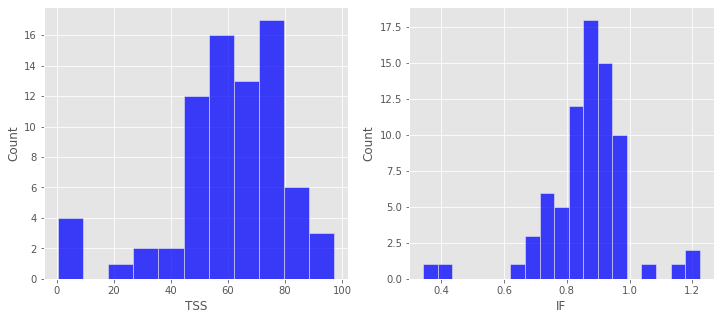

In [217]:
processed_data['IF'] = processed_data['NormPower'] / processed_data['UserMaxWatts']
processed_data['TSS'] = (processed_data['minutes']*60.0*processed_data['NormPower']*processed_data['IF'])/(processed_data['UserMaxWatts']*3600.0)*100.0

fig, ax = plt.subplots(1,2, figsize=(12,5))
sns.histplot(data=processed_data, x='TSS', ax=ax[0], color='blue')
sns.histplot(data=processed_data, x='IF', ax=ax[1], color='blue')

Looking at the IF and TSS distributions, the values are inside the ranges found in the previous references.

Going futher, since I go to the studio very often, data with good quality usually respects:
* Each training takes between 20 and 60 minutes.
* Average Power should be above 100 Watts. 

These issues are caused by failures in the communication between PerfPro and the Wattbikes. Looking at both variable's histogram, it is clear that there are invalid rows to de discarded.

<AxesSubplot:xlabel='aveWatts', ylabel='Count'>

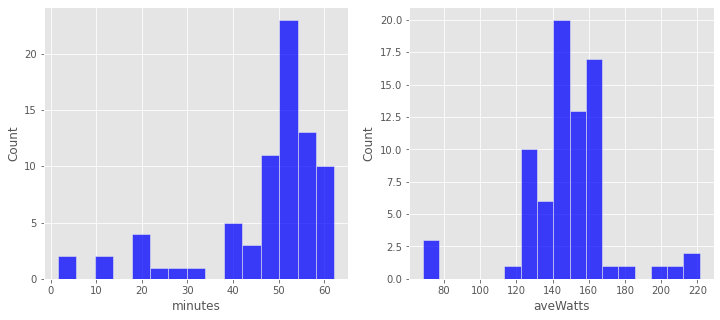

In [218]:
fig, ax = plt.subplots(1,2, figsize=(12,5))
sns.histplot(data=processed_data, x='minutes', ax=ax[0], color='blue')
sns.histplot(data=processed_data, x='aveWatts', ax=ax[1], color='blue')

In [219]:
MIN_MINUTES, MAX_MINUTES = 20, 60
MIN_POWER = 100
mask_minutes = (processed_data.minutes <= MAX_MINUTES) & (processed_data.minutes >= MIN_MINUTES)
mask_power = (processed_data.aveWatts >= MIN_POWER)

processed_data = processed_data.loc[mask_minutes,:]
processed_data = processed_data.loc[mask_power,:]

len_processed = processed_data.shape[0]
print(f'Applying this filter, a total of {len_original - len_processed} training sessions are discarded.')

Applying this filter, a total of 10 training sessions are discarded.


### Weight

There are also no missing values in this dataset, as seen below. There are also no invalid values, since the values are within the range I expected.

In [220]:
print(raw_weight.info())
display(raw_weight.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63 entries, 0 to 62
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Weight     63 non-null     float64       
 1   Timestamp  63 non-null     datetime64[ns]
dtypes: datetime64[ns](1), float64(1)
memory usage: 1.1 KB
None


,Weight
count,63.000000
mean,80.093651
std,1.308764
min,77.500000
25%,79.149998
50%,80.000000
75%,81.049999
max,84.199997


### Joining the Datasets

The PerfPro data already has a weight column, but its values are not updated regularly. Therefore, it is necessary to merge it with the Google Fit data. In order to do that, it is necessary to:
1. Resample the weight data and fill the days where there was no measurement. 
    * A linear interpolation strategy will be used, since the weight does not change too much from one period to another
2. Extract the day from the PerfPro dataset ann merge the datasets

In [221]:
processed_weight = raw_weight.copy()

# create the index column
processed_weight['Index'] = processed_weight['Timestamp'].dt.to_period('D')

# resample and interpolate the weight data
processed_weight = processed_weight.groupby('Index')['Weight'].mean()
processed_weight = processed_weight.resample('1D').interpolate()

# replace the weight in the perfpro data with the interpolated value
def get_weight_from_date(dateStamp):
    date_index = dateStamp.to_period('D')
    return processed_weight[date_index]

processed_data['userWeight'] = processed_data['dateStamp'].apply(get_weight_from_date)

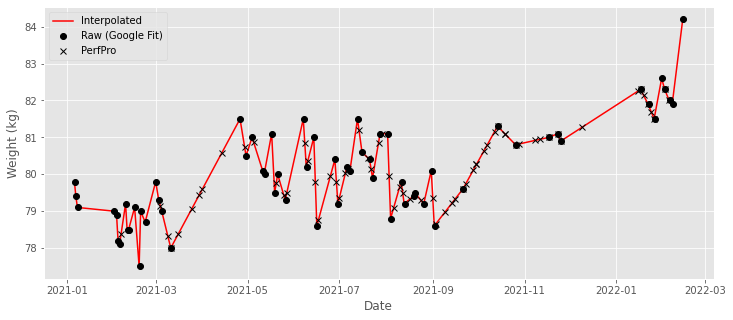

In [222]:
fig, ax = plt.subplots(figsize=(12,5))
ax.plot(processed_weight.index.to_timestamp(), processed_weight, label='Interpolated', color='r')
ax.plot(raw_weight.Timestamp, raw_weight.Weight, 'ko', label='Raw (Google Fit)')
ax.plot(processed_data.dateStamp.dt.to_period('D'), processed_data.userWeight, 'kx', label='PerfPro')
ax.set_ylabel('Weight (kg)')
ax.set_xlabel('Date')
ax.legend()

### Feature Engineering

The main performance indicator used in cycling is the [power-to-weight ratio](https://www.cyclingweekly.com/fitness/training/the-importance-of-power-to-weight-and-how-to-improve-yours-164589). Since we now have the weight information, it can be easily calculated.

In [223]:
# calculate the W/kg values
processed_data['W_per_kg'] = processed_data['NormPower'] / processed_data['userWeight']

## Analysis

### How is my performance evolving over time?

Let's have a look at my power-to-weight ratio. It is possible to notice that my highest performance occurred between July/2021 and October/2021, decreasing after this period. This is definitely expected because of these situations:

1. I was training to a challenging competition that happened late August/2021
2. I had to reduce my training intensity after October/2021 for personal reasons
3. I had an injury in December/2021 and was unable to train for around 45 days.

The takeway is that I could continue improving my performance, but that would have negatively affected other aspects of my life. It's very important to always try to keep life balanced, since I am not a pro cyclist.

Text(0.5, 0, 'Date')

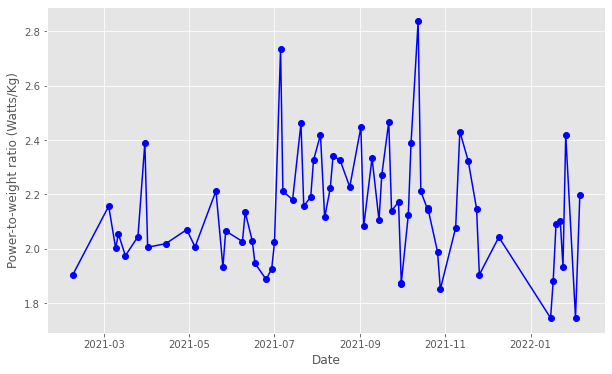

In [224]:
fig, ax = plt.subplots(figsize=(10,6))

ax.plot(processed_data.dateStamp, processed_data.W_per_kg, 'bo-', label='W/kg')

ax.set_ylabel('Power-to-weight ratio (Watts/Kg)')
ax.set_xlabel('Date')

### How is my pedalling technique?

The pedalling technique can be measured with the eft/right leg balance information: it should be as close to 50/50 as possible, but since it can fluctuate the ideal range is between 48%-52%. In this scenario, the athlete is applying force evenly with each leg resulting in an optimal power transfer to the bycicle. More information can be found in this link: https://support.wattbike.com/hc/en-us/articles/115001848609-A-Beginner-s-Guide-To-Perfect-Pedalling.

In order to do that, the distribution of each leg balance information is plotted in the figure below. It is possible to see that my pedalling technique is  inside the ideal range, but there is definitely some room to improve. 

For instance, I am applying more force with my left leg on average, so I could focus on stretching and strength training in the gym in order to improve this situation. This is a very interesting insight, and I was not aware!

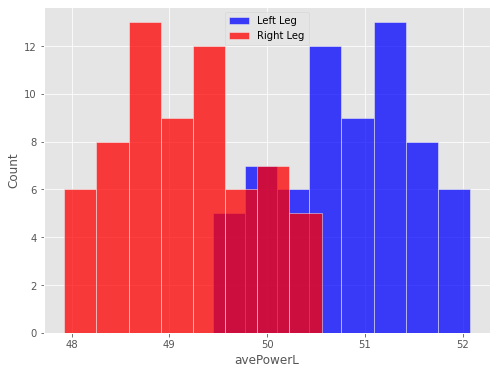

In [225]:
fig, ax = plt.subplots(figsize=(8,6))
sns.histplot(data=processed_data, x='avePowerL',ax=ax, color='blue', label='Left Leg')
sns.histplot(data=processed_data, x='avePowerR',ax=ax, color='red', label='Right Leg')
ax.legend()

### Can I group traininig sessions into different categories?

In order to find groups within the performances, the following steps will be followed: 

1. Remove multicollinear variables using hierarquical clustering. This techinque is inspired from this https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance_multicollinear.html
2. Find the groups using the K-means algorithm

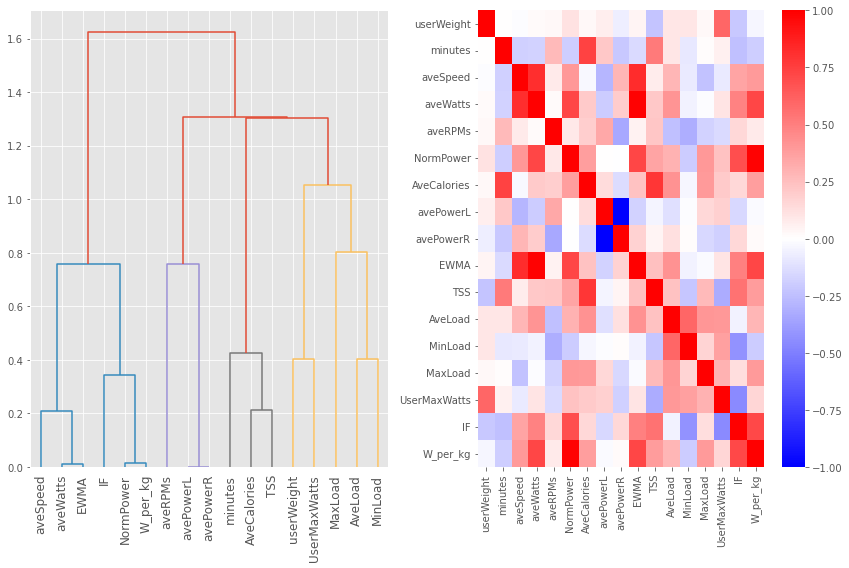

In [264]:
def build_hierarquical_cluster(corr_data):
    corr = spearmanr(corr_data.values).correlation
    # Ensure the correlation matrix is symmetric
    corr = (corr + corr.T) / 2
    np.fill_diagonal(corr, 1)

    # We convert the correlation matrix to a distance matrix before performing
    # hierarchical clustering using Ward's linkage.
    distance_matrix = 1 - np.abs(corr)
    dist_linkage = hierarchy.ward(squareform(distance_matrix))

    return dist_linkage

def plot_colinearity_analysis(dist_linkage, corr_data):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))

    hierarchy.dendrogram(
        dist_linkage, labels=corr_data.columns.tolist(), ax=ax1, leaf_rotation=90
    )
    sns.heatmap(corr_data.corr('spearman'), cmap='bwr', ax=ax2)

    fig.tight_layout()
    plt.show()

def get_selected_features(dist_linkage, dist_threshold = 1.0):
    cluster_ids = hierarchy.fcluster(dist_linkage, 1.0, criterion="distance")
    cluster_id_to_feature_ids = defaultdict(list)
    for idx, cluster_id in enumerate(cluster_ids):
        cluster_id_to_feature_ids[cluster_id].append(idx)
    selected_features = [v[0] for v in cluster_id_to_feature_ids.values()]

    return selected_features

corr_data = processed_data.drop(columns=['ID', 'Age', 'Gender', 'aveHR', 'UsingHRMonitor', 'dateStamp', 'units'])

dist_linkage = build_hierarquical_cluster(corr_data)
plot_colinearity_analysis(dist_linkage, corr_data)

In [290]:
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist

selected_features = get_selected_features(dist_linkage, 1.0)
corr_data_selected = corr_data[['TSS','avePowerL', 'W_per_kg']]   #pd.DataFrame(corr_data.values[:, selected_features], columns=corr_data.columns[selected_features])

distortions = []
inertias = []
mapping1 = {}
mapping2 = {}
K = range(1, 10)

for k in K:
    km = KMeans(n_clusters=k, random_state=0).fit(corr_data_selected)

    distortion = sum(np.min(cdist(corr_data_selected, km.cluster_centers_,'euclidean'), axis=1)) / corr_data_selected.shape[0]
    distortions.append(distortion)
    inertias.append(km.inertia_)
 
    mapping1[k] = distortion
    mapping2[k] = km.inertia_

C:\Users\victo\anaconda3\envs\dev-udacity\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


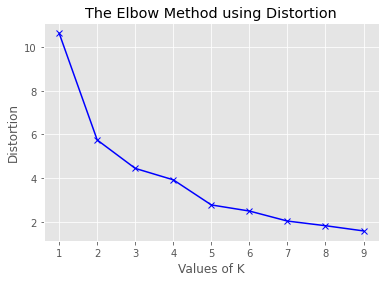

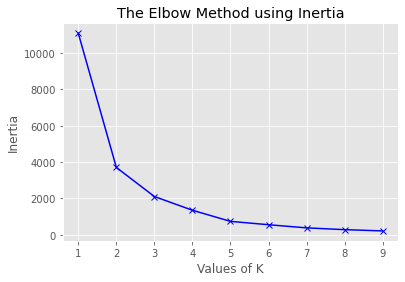

In [291]:
plt.plot(K, distortions, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Distortion')
plt.title('The Elbow Method using Distortion')
plt.show()

plt.plot(K, inertias, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Inertia')
plt.title('The Elbow Method using Inertia')
plt.show()

In [292]:
km = KMeans(n_clusters=3, random_state=0).fit(corr_data_selected)
corr_data_selected['group'] = km.predict(corr_data_selected)

C:\Users\victo\AppData\Local\Temp/ipykernel_13168/720431390.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  corr_data_selected['group'] = km.predict(corr_data_selected)


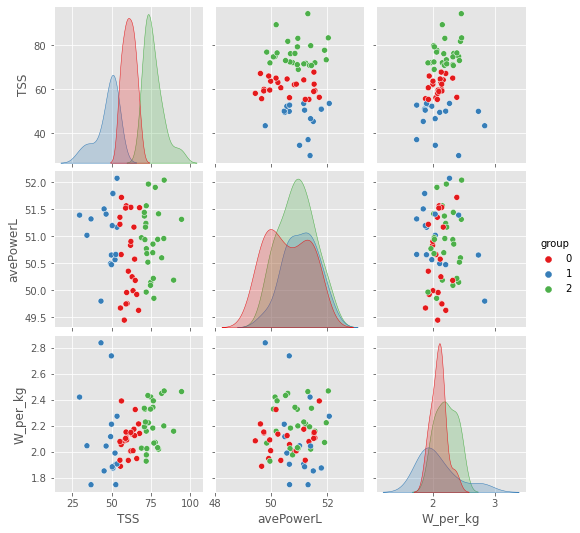

In [293]:
sns.pairplot(corr_data_selected, hue='group', palette='Set1')